In [30]:
import pandas as pd
import numpy as  np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import seaborn as sns
from scipy.optimize import curve_fit

%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [31]:
imc_data_file = '../data/data.csv'
kgh_data_file = '../../kenema/mirador/data.csv'
goal_data_file = '../../goal/data.csv'

imc_data = pd.read_csv(imc_data_file, na_values="\\N")

sl_data = imc_data[(imc_data['ETUKey'] == 2) | (imc_data['ETUKey'] == 4) | (imc_data['ETUKey'] == 5)]
lb_data = imc_data[(imc_data['ETUKey'] == 1) | (imc_data['ETUKey'] == 3)]

sl_data = sl_data[sl_data['Disposition'].notnull()]
lb_data = lb_data[lb_data['Disposition'].notnull()]

kgh_data = pd.read_csv(kgh_data_file, na_values="\\N")
goal_data = pd.read_csv(goal_data_file, na_values='\\N')

In [32]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

def plotCTHist(data, ctvar, outvar, out1, out0, label, plotDS):
    sns.set_style("ticks", {'axes.grid': False})
    
    grey='darkgrey'
    red="#c94741"
    blue="#3783bb"

    fig, ax = plt.subplots()

    plt.title(label)
    plt.xlabel('Cycle Threshold', labelpad=15)
    plt.ylabel('Number of Cases', labelpad=15)
    plt.xlim(left = 10, right = 40)
#     plt.ylim(bottom = 0, top = 45)

    # sl_dead[ct_var].hist(bins=10, alpha=0.75, color='red')
    # sl_surv[ct_var].hist(bins=10, alpha=0.75, color='blue')

    dead = data[data[outvar] == out1]
    surv = data[data[outvar] == out0]    

    p1 = plt.hist(data[ctvar], bins=10, alpha=0.85, color=grey)
    if plotDS:
        p2 = plt.hist(dead[ctvar], bins=10, alpha=0.85, color=red)
        p3 = plt.hist(surv[ctvar], bins=10, alpha=0.85, color=blue)
        all_legend = patch.Patch(color=grey, label='All')
        dead_legend = patch.Patch(color=red, label='Died')
        surv_legend = patch.Patch(color=blue, label='Survived')
        lgd = plt.legend(handles=[all_legend, dead_legend, surv_legend], bbox_to_anchor=(0.76, 0.97), loc=2, borderaxespad=0.)        
        fig.savefig(label + '.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        fig.savefig(label + '.pdf', bbox_inches='tight')
        
def plotCTDist(data, ctvar, outvar, out1, out0, label):
    minct = data[ctvar].min()
    maxct = data[ctvar].max()

    nbins = 8
    bins = np.linspace(0, 40, nbins + 1)
    middle = np.linspace(2.5, 37.5, nbins)

    bin_names = []
    for ct in bins[:-1]:
        bin_names += [str(int(ct)) + '-' + str(int(ct + 5.0))]

    data1 = data.copy()
    binned = pd.cut(data[ctvar], bins)
    data2 = pd.DataFrame()
    data2['Outcome'] = data1[outvar]
    data2['CT'] = binned
    data2.dropna(inplace=True)

    # Count number of total, diseased, and recovered patients
    tot = pd.value_counts(data2['CT'], sort=False)
    died = pd.value_counts(data2[data2['Outcome'] == out1]['CT'], sort=False)
    rec = pd.value_counts(data2[data2['Outcome'] == out0]['CT'], sort=False)

    # CFR in %
    cfr = 100 * died / tot
    data3 = pd.DataFrame()
    data3['CFR'] = cfr
    data3['Count'] = tot

    fig = plt.figure()
    plt.xlim(left = 0, right = 40)
    plt.ylim(bottom = 0, top = 110)    
     
    ax1 = data3.CFR.plot(kind='bar', color=sns.xkcd_rgb["pale red"], width=0.5, alpha=0.8)   

    ax1.set_xlabel('CT', labelpad=20)
    ax1.set_ylabel('CFR %')
    ax1.set_xticklabels(bin_names, rotation=45)
    plt.title(label)
    
    fig.savefig(label + '.pdf', bbox_inches='tight')

def plotCTCurve(data, ctvar, lowct, outvar, out1, out0, label):
    minct = data[ctvar].min()
    maxct = data[ctvar].max()

    nbins = 8
    bins = np.linspace(0, 40, nbins + 1)
    middle = np.linspace(2.5, 37.5, nbins)

    bin_names = []
    for ct in bins[:-1]:
        bin_names += [str(int(ct)) + '-' + str(int(ct + 5.0))]

    data1 = data.copy()
    binned = pd.cut(data[ctvar], bins)
    data2 = pd.DataFrame()
    data2['Outcome'] = data1[outvar]
    data2['CT'] = binned
    data2.dropna(inplace=True)

    # Count number of total, diseased, and recovered patients
    tot = pd.value_counts(data2['CT'], sort=False)
    died = pd.value_counts(data2[data2['Outcome'] == out1]['CT'], sort=False)
    rec = pd.value_counts(data2[data2['Outcome'] == out0]['CT'], sort=False)

    # CFR in %
    cfr = 100 * died / tot
    data3 = pd.DataFrame()
    data3['CFR'] = cfr
    data3['Count'] = tot
    
    xdata = middle.copy()
    ydata = np.array(list(data3['CFR']))
    ydata[np.isnan(ydata)] = 100
    idx0 = np.argmin(ydata)
    if ydata[idx0] == 0:
        xdata = xdata[:idx0]
        ydata = ydata[:idx0]

#     print(lowct)
#     print(xdata)
#     print(ydata)    
    
    xdata_norm = xdata - lowct
    ydata_norm = (ydata - ydata.min())/(ydata.max() - ydata.min())
    
    popt, pcov = curve_fit(sigmoid, xdata_norm, ydata_norm)
    x = np.linspace(-20, 20, 80)
    y = sigmoid(x, *popt)
    x = x + lowct
    y = (ydata.max() - ydata.min()) * y + ydata.min()

    
    fig = plt.figure()
    plt.xlim(left = 0, right = 40)
    plt.ylim(bottom = 0, top = 110)    
    plt.plot(x, y)
    plt.plot([lowct, lowct], [0, 110], c='grey')

#     ax1.set_xlabel('CT', labelpad=20)
#     ax1.set_ylabel('CFR %')
#     ax1.set_xticklabels(bin_names, rotation=45)
    plt.title(label)
    
#     fig.savefig('ct_hist-sierra_leone.pdf', bbox_inches='tight')    

## Viral load

In [33]:
ct_var = 'cycletime'
out_var = 'Disposition'
out1 = 1
out0 = 0

imc_dead = imc_data[imc_data[out_var] == out1]
imc_surv = imc_data[imc_data[out_var] == out0]

print('Mean (SD) CT in fatal IMC cases %0.2f (%0.2f)' % (imc_dead[ct_var].mean(), imc_dead[ct_var].std()))
print('Mean (SD) CT in surviving IMC cases %0.2f (%0.2f)' % (imc_surv[ct_var].mean(), imc_surv[ct_var].std()))

# imc_dead[ct_var].plot.kde() 
# imc_surv[ct_var].plot.kde() 

Mean (SD) CT in fatal IMC cases 22.23 (5.64)
Mean (SD) CT in surviving IMC cases 26.72 (5.51)


In [34]:
ct_var = 'cycletime'
out_var = 'Disposition'
out1 = 1
out0 = 0

sl_dead = sl_data[sl_data[out_var] == out1]
sl_surv = sl_data[sl_data[out_var] == out0]

print('Mean (SD) CT in all Sierra Leone IMC cases %0.2f (%0.2f)' % (sl_data[ct_var].mean(), sl_data[ct_var].std()))
print('Mean (SD) CT in fatal Sierra Leone IMC cases', sl_dead[ct_var].mean(), sl_dead[ct_var].std())
print('Mean (SD) CT in surviving Sierra Leone  IMC cases', sl_surv[ct_var].mean(), sl_surv[ct_var].std())
print('Median CT in fatal Sierra Leone IMC cases %0.2f' % sl_data[ct_var].median())
print('Median CT in surviving Sierra Leone IMC cases %0.2f' % sl_surv[ct_var].median())

# sl_dead[ct_var].plot.kde() 
# sl_surv[ct_var].plot.kde() 

Mean (SD) CT in all Sierra Leone IMC cases 21.82 (5.16)
Mean (SD) CT in fatal Sierra Leone IMC cases 20.23532793139344 4.530769307827888
Mean (SD) CT in surviving Sierra Leone  IMC cases 24.40226676893333 5.118011218141871
Median CT in fatal Sierra Leone IMC cases 20.76
Median CT in surviving Sierra Leone IMC cases 23.20


In [35]:
ct_var = 'cycletime'
out_var = 'Disposition'
out1 = 1
out0 = 0

lb_dead = lb_data[lb_data[out_var] == out1]
lb_surv = lb_data[lb_data[out_var] == out0]

print('Mean (SD) CT in all Liberia IMC cases %0.2f (%0.2f)' % (lb_data[ct_var].mean(), lb_data[ct_var].std()))
print('Mean (SD) CT in fatal Liberia IMC cases %0.2f (%0.2f)' % (lb_dead[ct_var].mean(), lb_dead[ct_var].std()))
print('Mean (SD) CT in surviving Liberia IMC cases %0.2f (%0.2f)' % (lb_surv[ct_var].mean(), lb_surv[ct_var].std()))
print('Median CT in fatal Liberia IMC cases %0.2f' % lb_dead[ct_var].median())
print('Median CT in surviving Liberia IMC cases %0.2f' % lb_surv[ct_var].median())

# lb_dead[ct_var].plot.kde() 
# lb_surv[ct_var].plot.kde() 

Mean (SD) CT in all Liberia IMC cases 27.67 (5.45)
Mean (SD) CT in fatal Liberia IMC cases 25.98 (5.64)
Mean (SD) CT in surviving Liberia IMC cases 29.31 (4.75)
Median CT in fatal Liberia IMC cases 24.50
Median CT in surviving Liberia IMC cases 28.70


In [36]:
t, p = ttest_ind(sl_dead['cycletime'].dropna(), lb_dead['cycletime'].dropna(), equal_var = False)
print("PValue of the difference of means test for fatal cases between Sierra Leone and Liberia", p)

t, p = ttest_ind(sl_surv['cycletime'].dropna(), lb_surv['cycletime'].dropna(), equal_var = False)
print("PValue of the difference of means test for surviving cases between Sierra Leone and Liberia", p)

PValue of the difference of means test for fatal cases between Sierra Leone and Liberia 1.450851465648992e-10
PValue of the difference of means test for surviving cases between Sierra Leone and Liberia 2.2549199352977667e-08


In [37]:
min_ct = imc_data['cycletime'].min()
max_ct = imc_data['cycletime'].max()
min_log_pcr = kgh_data['PCR'].min()
max_log_pcr = kgh_data['PCR'].max()
print(min_ct, max_log_pcr) 
print(max_ct, min_log_pcr) 
b = (max_log_pcr - min_log_pcr) / (max_ct - min_ct)
a = min_log_pcr + b * max_ct
vl2ct_c1 = -1/b
vl2ct_c0 = +a/b
print(3*b)
print(vl2ct_c1, vl2ct_c0)

kgh_data['CT'] = vl2ct_c1 * kgh_data['PCR'] + vl2ct_c0

12.10000038 10.56304728
39.79999924 1.546663713
0.9765036756034003
-3.072185056698576 44.55163638681653


In [38]:
ct_var = 'CT'
out_var = 'OUT'
out1 = 1
out0 = 0

kgh_dead = kgh_data[kgh_data[out_var] == out1]
kgh_surv = kgh_data[kgh_data[out_var] == out0]

print('Mean CT in all KGH cases %0.2f (%0.2f)' % (kgh_data[ct_var].mean(), kgh_data[ct_var].std()))
print('Mean CT in fatal KGH cases %0.2f (%0.2f)' % (kgh_dead[ct_var].mean(), kgh_dead[ct_var].std()))
print('Mean CT in surviving KGH cases %0.2f (%0.2f)' % (kgh_surv[ct_var].mean(), kgh_surv[ct_var].std()))
print('Median CT in fatal KGH cases %0.2f' % kgh_dead[ct_var].median())
print('Median CT in surviving KGH cases %0.2f' % kgh_surv[ct_var].median())

# kgh_dead['CT'].plot.kde() 
# kgh_surv['CT'].plot.kde() 

Mean CT in all KGH cases 26.05 (6.00)
Mean CT in fatal KGH cases 24.28 (4.83)
Mean CT in surviving KGH cases 30.71 (5.77)
Median CT in fatal KGH cases 24.73
Median CT in surviving KGH cases 31.10


In [39]:
ct_var = 'evd_ct'
out_var = 'death'
out1 = 1
out0 = 0

goal_dead = goal_data[goal_data[out_var] == True]
goal_surv = goal_data[goal_data[out_var] == False]

print('Mean CT in all GOAL IMC cases %0.2f (%0.2f)' % (goal_data[ct_var].mean(), goal_data[ct_var].std()))
print('Mean CT in fatal GOAL cases %0.2f (%0.2f)' % (goal_dead[ct_var].mean(), goal_dead[ct_var].std()))
print('Mean CT in surviving GOAL cases %0.2f (%0.2f)' % (goal_surv[ct_var].mean(), goal_surv['evd_ct'].std()))
print('Median CT in fatal GOAL cases %0.2f' % goal_dead[ct_var].median())
print('Median CT in surviving GOAL cases %0.2f' % goal_surv[ct_var].median())

# goal_dead['evd_ct'].plot.kde() 
# goal_surv['evd_ct'].plot.kde() 

Mean CT in all GOAL IMC cases 22.20 (4.31)
Mean CT in fatal GOAL cases 20.73 (3.75)
Mean CT in surviving GOAL cases 24.79 (4.04)
Median CT in fatal GOAL cases 19.50
Median CT in surviving GOAL cases 24.05


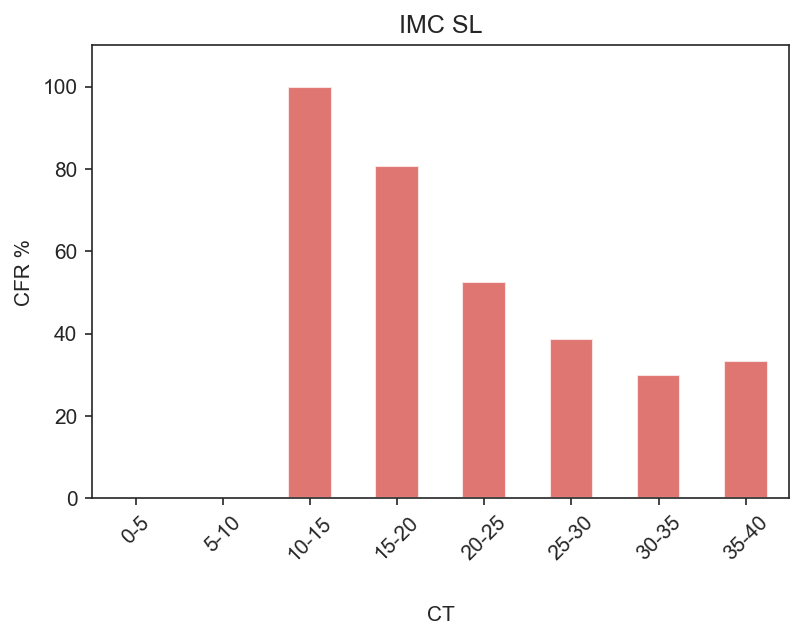

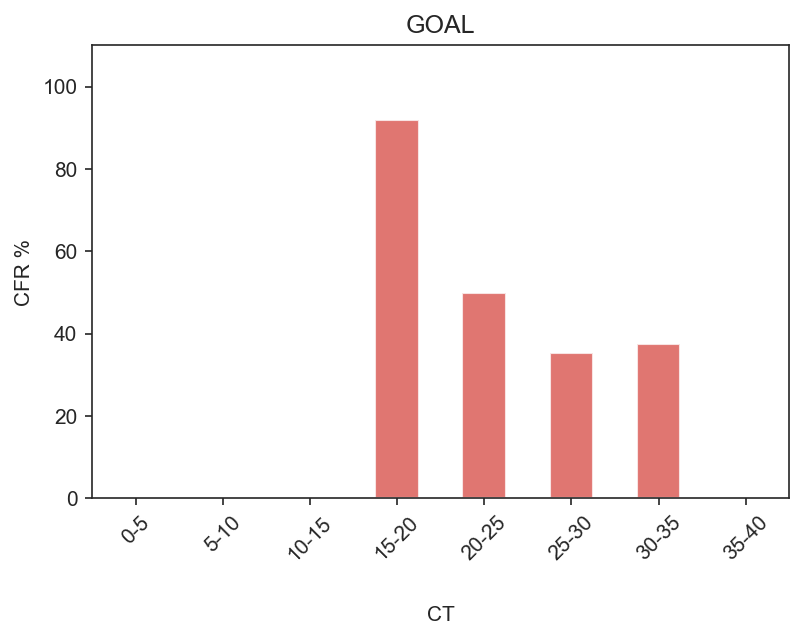

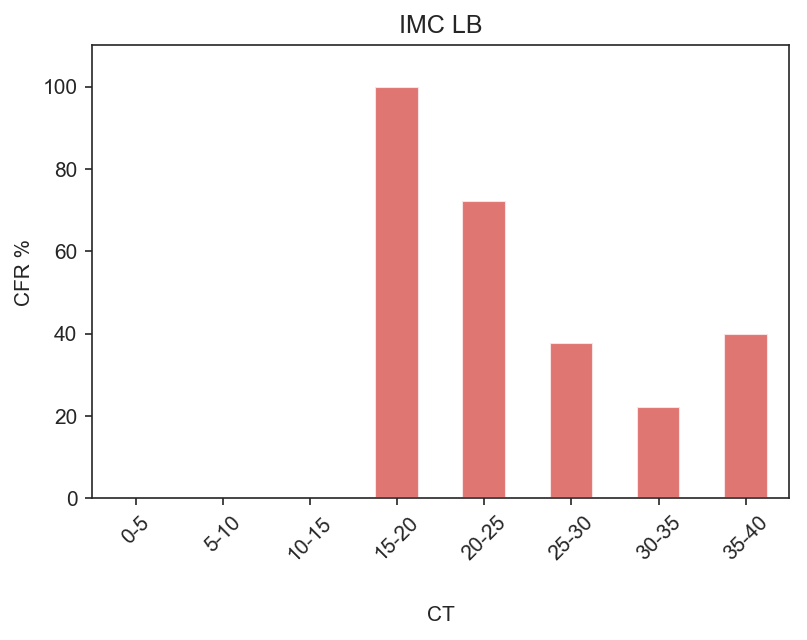

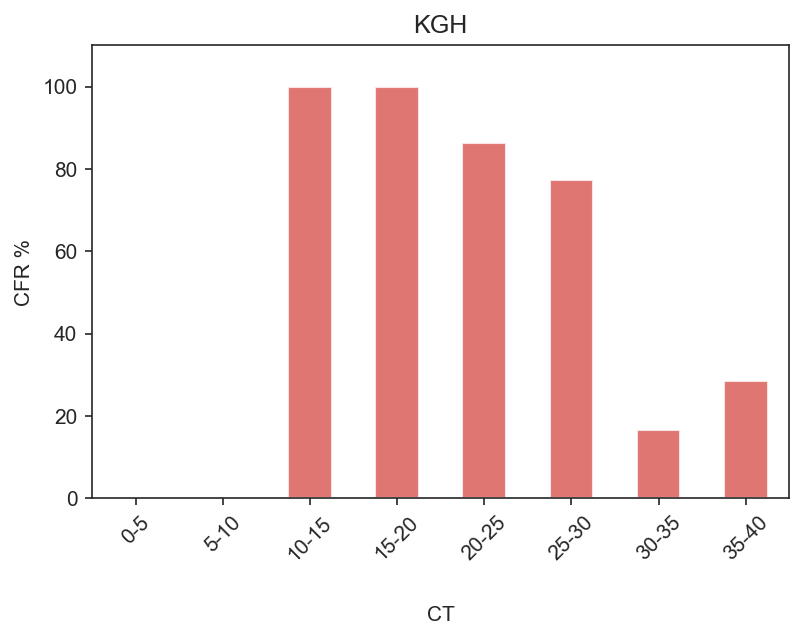

In [40]:
plotCTDist(sl_data, 'cycletime', 'Disposition', 1, 0, 'IMC SL')
plotCTDist(goal_data, 'evd_ct', 'death', True, False, 'GOAL')
plotCTDist(lb_data, 'cycletime', 'Disposition', 1, 0, 'IMC LB')
plotCTDist(kgh_data, 'CT', 'OUT', 1, 0, 'KGH')

In [41]:
# plotCTCurve(sl_data, 'cycletime', 20, 'Disposition', 1, 0, 'IMC SL')
# plotCTCurve(goal_data, 'evd_ct', 20, 'death', True, False, 'GOAL')
# plotCTCurve(lb_data, 'cycletime', 25, 'Disposition', 1, 0, 'IMC LB')
# plotCTCurve(kgh_data, 'CT', 25, 'OUT', 1, 0, 'KGH')

/Users/andres/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/andres/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


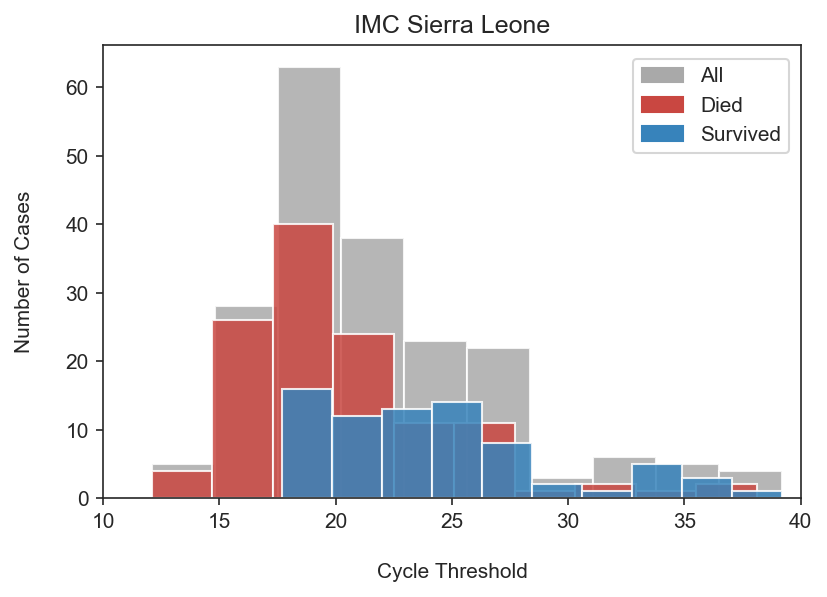

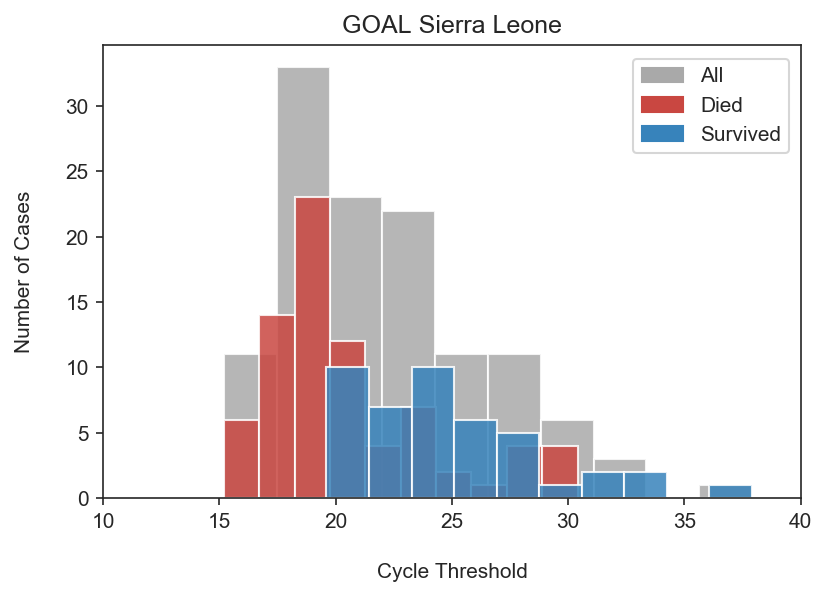

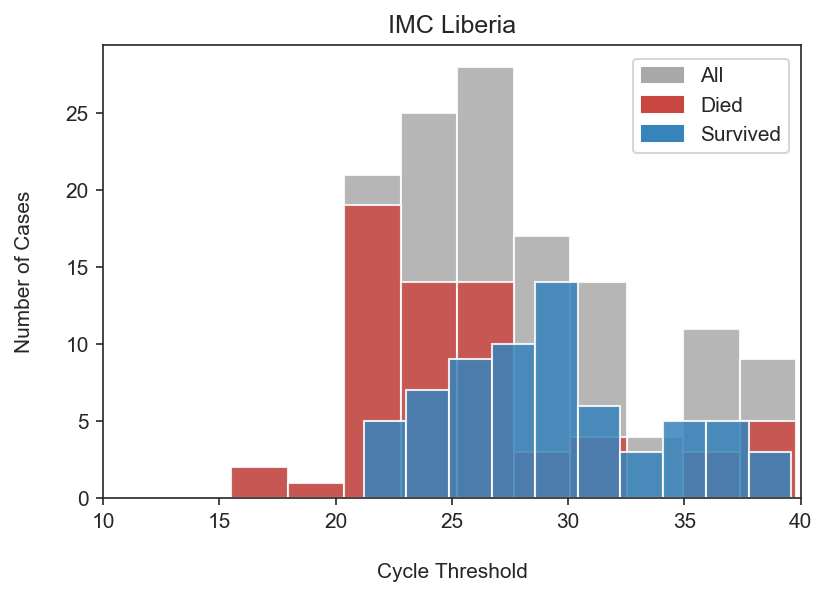

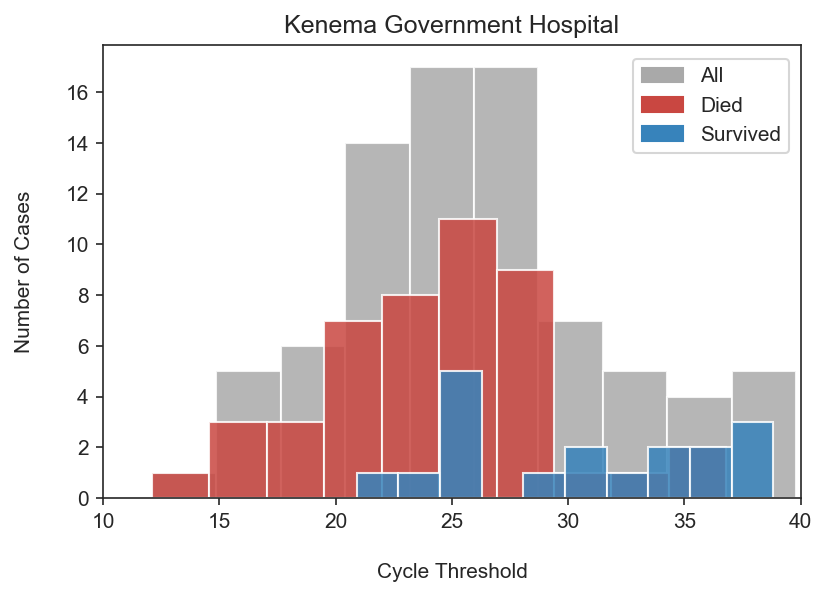

In [42]:
plotCTHist(sl_data, 'cycletime', 'Disposition', 1, 0, 'IMC Sierra Leone', True)
plotCTHist(goal_data, 'evd_ct', 'death', True, False, 'GOAL Sierra Leone', True)
plotCTHist(lb_data, 'cycletime', 'Disposition', 1, 0, 'IMC Liberia', True)
plotCTHist(kgh_data, 'CT', 'OUT', 1, 0, 'Kenema Government Hospital', True)

In [43]:
t, p = ttest_ind(sl_data['cycletime'].dropna(), lb_data['cycletime'].dropna(), equal_var = False)
print("PValue of the difference of means test for all cases between Sierra Leone and Liberia", p)

t, p = ttest_ind(sl_data['cycletime'].dropna(), kgh_data['CT'].dropna(), equal_var = False)
print("PValue of the difference of means test for all cases between IMC Sierra Leone and KGH", p)

t, p = ttest_ind(lb_data['cycletime'].dropna(), kgh_data['CT'].dropna(), equal_var = False)
print("PValue of the difference of means test for all cases between IMC Liberia and KGH", p)

t, p = ttest_ind(goal_data['evd_ct'].dropna(), lb_data['cycletime'].dropna(), equal_var = False)
print("PValue of the difference of means test for all cases between GOAL and IMC Liberia", p)

t, p = ttest_ind(goal_data['evd_ct'].dropna(), sl_data['cycletime'].dropna(), equal_var = False)
print("PValue of the difference of means test for all cases between GOAL and IMC Sierra Leone", p)

t, p = ttest_ind(goal_data['evd_ct'].dropna(), kgh_data['CT'].dropna(), equal_var = False)
print("PValue of the difference of means test for all cases between GOAL and KGH", p)

PValue of the difference of means test for all cases between Sierra Leone and Liberia 1.995743902245686e-19
PValue of the difference of means test for all cases between IMC Sierra Leone and KGH 1.5344769498050182e-07
PValue of the difference of means test for all cases between IMC Liberia and KGH 0.04882486400427003
PValue of the difference of means test for all cases between GOAL and IMC Liberia 1.40542481817019e-16
PValue of the difference of means test for all cases between GOAL and IMC Sierra Leone 0.4766203281930548
PValue of the difference of means test for all cases between GOAL and KGH 2.0341442590383404e-06


Optimization terminated successfully.
         Current function value: 0.584092
         Iterations: 8
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.643483
         Iterations: 8
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.546065
         Iterations: 9
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.459956
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15


/Users/andres/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/andres/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


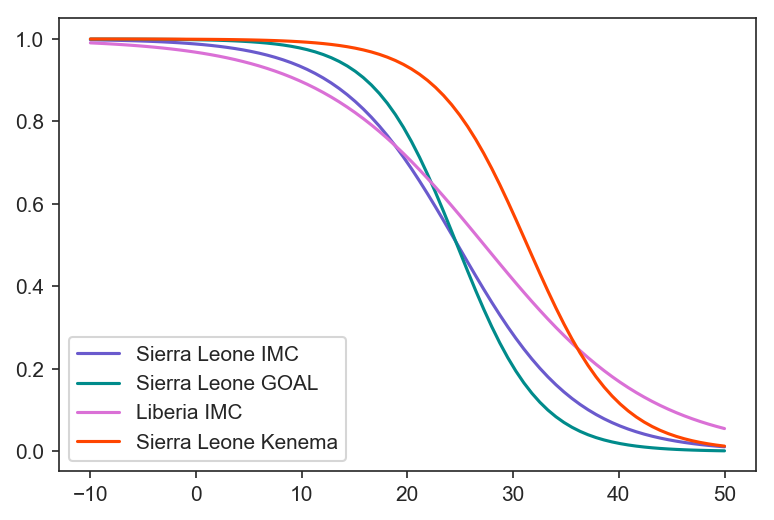

In [44]:
import statsmodels.api as sm

def sigmoid(ct, theta):
    z = np.array([1, ct])
    v = np.dot(z, theta)
    return 1.0 / (1.0 + np.exp(-v))

def genModel(dat, ctvar, outvar):
#     dat.replace(True, 1.0, inplace=True)
#     dat.replace(False, 0.0, inplace=True)    
    dat['intercept'] = 1.0

    train_cols = ['intercept', ctvar]
    
    logit = sm.Logit(dat[outvar], dat[train_cols], missing='drop')
        # fit the model
    #     result = logit.fit(method='newton') # Might throw LinAlgError: Singular matrix 
    result = logit.fit(method='bfgs')

    params = result.params

    x = np.linspace(-10, 50, 80)
    y = sigmoid(x, params)
    return x, y
    
slx, sly = genModel(sl_data.copy(), 'cycletime', 'Disposition')
lbx, lby = genModel(lb_data.copy(), 'cycletime', 'Disposition')
d = goal_data[['evd_ct', 'death']]
# d.replace(True, 1.0, inplace=True)
# d.replace(False, 0.0, inplace=True)

d.death = d.death.astype(int)

# print(d)
glx, gly = genModel(d, 'evd_ct', 'death')
knx, kby = genModel(kgh_data.copy(), 'CT', 'OUT')

plt.plot(slx, sly, label='Sierra Leone IMC', color='slateblue')
plt.plot(glx, gly, label='Sierra Leone GOAL', color='darkcyan')
plt.plot(lbx, lby, label='Liberia IMC', color='orchid')
plt.plot(knx, kby, label='Sierra Leone Kenema', color='orangered')
plt.legend(loc='best')

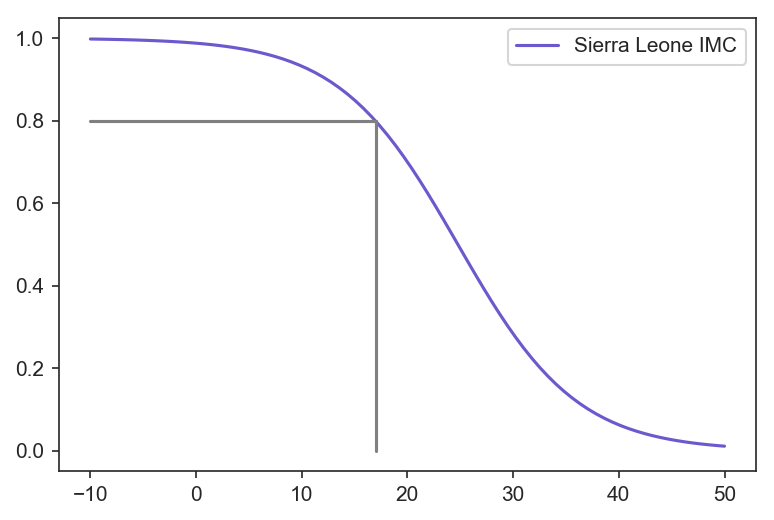

In [45]:
plt.plot(slx, sly, label='Sierra Leone IMC', color='slateblue')
ctv = 17
plt.plot([-10, ctv], [0.8, 0.8], c='grey')
plt.plot([ctv, ctv], [0, 0.8], c='grey')
plt.legend(loc='best')

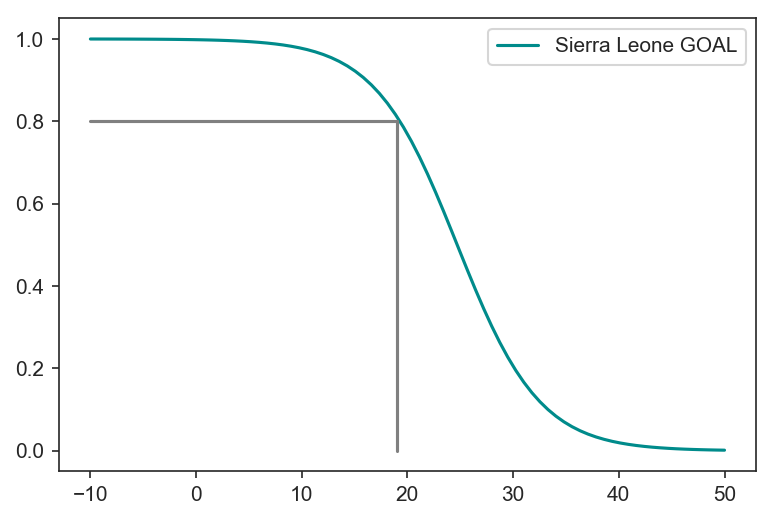

In [46]:
plt.plot(glx, gly, label='Sierra Leone GOAL', color='darkcyan')
ctv = 19
plt.plot([-10, ctv], [0.8, 0.8], c='grey')
plt.plot([ctv, ctv], [0, 0.8], c='grey')
plt.legend(loc='best')

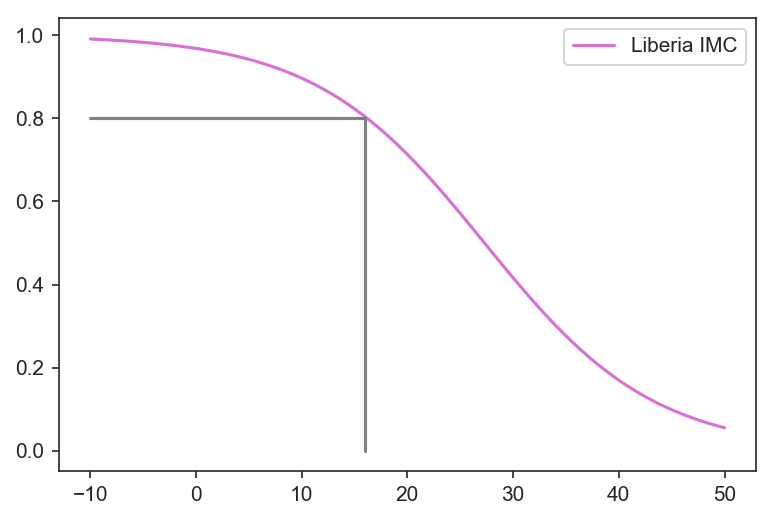

In [47]:
plt.plot(lbx, lby, label='Liberia IMC', color='orchid')
ctv = 16
plt.plot([-10, ctv], [0.8, 0.8], c='grey')
plt.plot([ctv, ctv], [0, 0.8], c='grey')
plt.legend(loc='best')

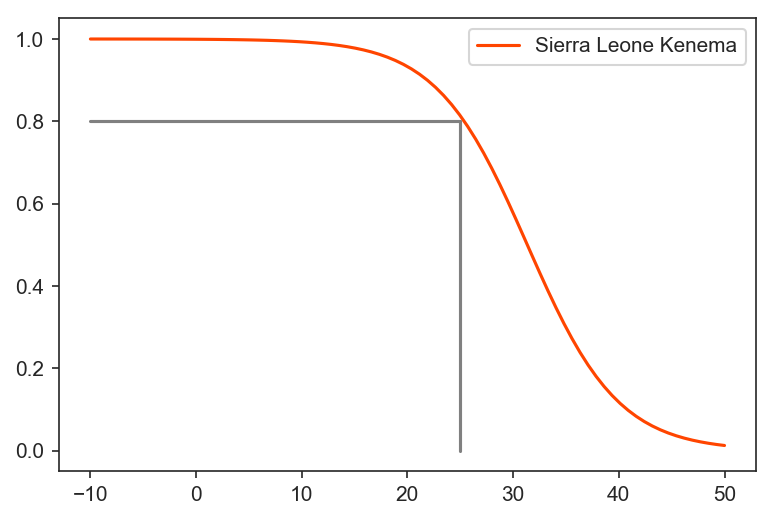

In [48]:
plt.plot(knx, kby, label='Sierra Leone Kenema', color='orangered')
ctv = 25
plt.plot([-10, ctv], [0.8, 0.8], c='grey')
plt.plot([ctv, ctv], [0, 0.8], c='grey')
plt.legend(loc='best')

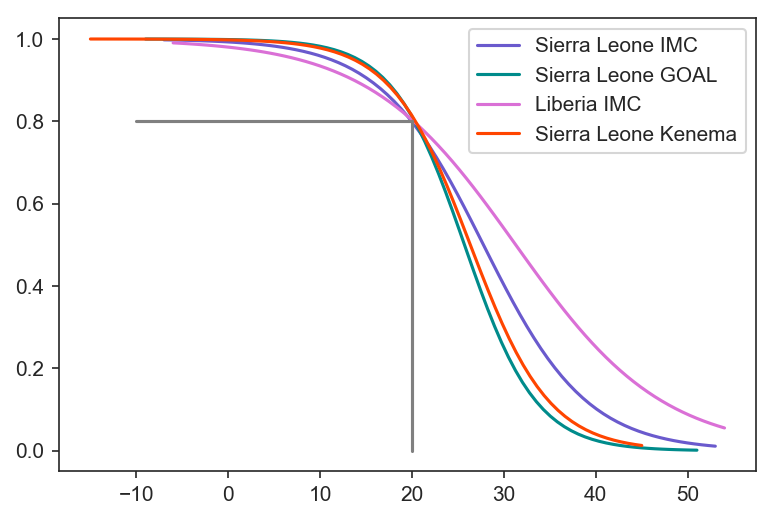

In [49]:
correction = 20 - 17
plt.plot(slx + correction, sly, label='Sierra Leone IMC', color='slateblue')

correction = 20 - 19
plt.plot(glx + correction, gly, label='Sierra Leone GOAL', color='darkcyan')

correction = 20 - 16
plt.plot(lbx + correction, lby, label='Liberia IMC', color='orchid')

correction = 20 - 25
plt.plot(knx + correction, kby, label='Sierra Leone Kenema', color='orangered')

ctv = 20
plt.plot([-10, ctv], [0.8, 0.8], c='grey')
plt.plot([ctv, ctv], [0, 0.8], c='grey')

plt.legend(loc='best')

## Referral times

In [50]:
rt_var = 'DaysSinceSymptomFeverOnset'
ct_var = 'cycletime'
out_var = 'Disposition'

print('Referral time in all IMC cases', imc_data[rt_var].mean(), imc_data[rt_var].std())
print('Referral time in Sierra Leone IMC cases', sl_data[rt_var].mean(), sl_data[rt_var].std())
print('Referral time in Liberia IMC cases', lb_data[rt_var].mean(), lb_data[rt_var].std())

Referral time in all IMC cases 4.232044198895028 3.3653391687960292
Referral time in Sierra Leone IMC cases 4.076086956521739 3.372125193444941
Referral time in Liberia IMC cases 4.390804597701149 3.3911013159455514


In [51]:
out1 = 1
out0 = 0

print('Referral time in fatal Sierra Leone IMC cases', sl_dead[rt_var].mean(), sl_dead[rt_var].std())
print('Referral time in surviving Sierra Leone IMC cases', sl_surv[rt_var].mean(), sl_surv[rt_var].std())

# dat = sl_data[ct_var].dropna()

dat = sl_data.dropna(subset = [ct_var])

ntot = dat[rt_var].isnull().sum()
print('Total missing referral times in Sierra Leone data', ntot)

lowct_data = dat[dat[ct_var] <= 25]
higct_data = dat[dat[ct_var] > 25]

print('Fraction missing when CT is low', lowct_data[rt_var].isnull().sum() / ntot)
print('Fraction missing when CT is high', higct_data[rt_var].isnull().sum() / ntot)

# sl_dead['reftime'].plot.kde() 
# sl_surv['reftime'].plot.kde() 

# sns.set_style("ticks", {'axes.grid': False})
# red="#c94741"
# blue="#3783bb"

# fig, ax = plt.subplots()

# plt.title('Sierra Leone ETUs')
# plt.xlabel('Referral time', labelpad=15)
# plt.ylabel('Number of Cases', labelpad=15)
# plt.xlim(left = 0, right = 20)
# plt.ylim(bottom = 0, top = 45)

# p1 = plt.hist(sl_dead[rt_var], bins=10, alpha=0.85, color=red)
# p2 = plt.hist(sl_surv[rt_var], bins=25, alpha=0.85, color=blue)
# dead_legend = patch.Patch(color=red, label='Died')
# surv_legend = patch.Patch(color=blue, label='Survived')
# lgd = plt.legend(handles=[dead_legend, surv_legend], bbox_to_anchor=(0.76, 0.97), loc=2, borderaxespad=0.)

# fig.savefig('ct_hist-sierra_leone.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Referral time in fatal Sierra Leone IMC cases 3.9051724137931036 2.6407457717252076
Referral time in surviving Sierra Leone IMC cases 4.367647058823529 4.3534320369610695
Total missing referral times in Sierra Leone data 65
Fraction missing when CT is low 0.7384615384615385
Fraction missing when CT is high 0.26153846153846155


In [52]:
print('Referral time in fatal Liberia IMC cases', lb_dead[rt_var].mean(), lb_dead[rt_var].std())
print('Referral time in surviving Liberia IMC cases', lb_surv[rt_var].mean(), lb_surv[rt_var].std())

# lb_dead['reftime'].plot.kde() 
# lb_surv['reftime'].plot.kde() 

# sns.set_style("ticks", {'axes.grid': False})
# red="#c94741"
# blue="#3783bb"

# fig, ax = plt.subplots()

# sl_ax = sl_surv[ct_var].plot
# lb_ax = lb_surv[ct_var].plot

# plt.title('Liberia ETUs')
# plt.xlabel('Cycle Threshold', labelpad=15)
# plt.ylabel('Number of Cases', labelpad=15)
# plt.xlim(left = 0, right=20)
# plt.ylim(bottom = 0, top = 45)

# plt.hist(lb_dead[rt_var], bins=10, alpha=0.85, color=red)
# plt.hist(lb_surv[rt_var], bins=10, alpha=0.85, color=blue)
# lgd = plt.legend(handles=[dead_legend, surv_legend], bbox_to_anchor=(0.76, 0.97), loc=2, borderaxespad=0.)

# fig.savefig('ct_hist-liberia.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

Referral time in fatal Liberia IMC cases 4.559139784946237 3.194636692929729
Referral time in surviving Liberia IMC cases 4.197530864197531 3.613930523289081


In [53]:
print('Referral time in fatal KGH cases', kgh_dead['DONSET'].mean(), kgh_dead['DONSET'].std())
print('Referral time in surviving KGH cases', kgh_surv['DONSET'].mean(), kgh_surv['DONSET'].std())

# kgh_dead['DONSET'].plot.kde() 
# kgh_surv['DONSET'].plot.kde() 

Referral time in fatal KGH cases 5.7272727272727275 1.8488325554743508
Referral time in surviving KGH cases 8.5 7.7781745930520225


In [54]:
print('Referral time in fatal GOAL cases', goal_dead['referral_time'].mean(), goal_dead['referral_time'].std())
print('Referral time in surviving GOAL cases', goal_surv['referral_time'].mean(), goal_surv['referral_time'].std())

# goal_dead['referral_time'].plot.kde() 
# goal_surv['referral_time'].plot.kde() 

Referral time in fatal GOAL cases 3.7027027027027026 2.57878451632478
Referral time in surviving GOAL cases 4.557377049180328 3.584803993544298


In [55]:
print("CFR in Sierra Leone", len(sl_data[sl_data[out_var] == 1]) / len(sl_data))
print("")

low_ct = 20

lowct_dat = sl_data[sl_data[ct_var] <= 20]
higct_dat = sl_data[20 < sl_data[ct_var]]

lowct_died_dat = lowct_dat[lowct_dat[out_var] == 1]
lowct_surv_dat = lowct_dat[lowct_dat[out_var] == 0]
lt, lp = ttest_ind(lowct_died_dat[rt_var].dropna(), 
                   lowct_surv_dat[rt_var].dropna(), equal_var = False)

higct_died_dat = higct_dat[higct_dat[out_var] == 1]
higct_surv_dat = higct_dat[higct_dat[out_var] == 0]
ht, hp = ttest_ind(higct_died_dat[rt_var].dropna(), 
                   higct_surv_dat[rt_var].dropna(), equal_var = False)

print("Referral time fatal cases in SL with high VL", lowct_died_dat[rt_var].mean(),
                                                      lowct_died_dat[rt_var].std())
print("Referral time surv. cases in SL with high VL", lowct_surv_dat[rt_var].mean(), 
                                                      lowct_surv_dat[rt_var].std())
print("P-Value of difference", lp)
print("     ")
print("Referral time fatal cases in SL with low VL", higct_died_dat[rt_var].mean(), 
                                                     higct_died_dat[rt_var].std())
print("Referral time surv. cases in SL with low VL", higct_surv_dat[rt_var].mean(),
                                                     higct_surv_dat[rt_var].std())
print("P-Value of difference", hp)

CFR in Sierra Leone 0.6027874564459931

Referral time fatal cases in SL with high VL 3.6346153846153846 2.393036025177617
Referral time surv. cases in SL with high VL 5.888888888888889 9.597453365925313
P-Value of difference 0.5028371132020687
     
Referral time fatal cases in SL with low VL 4.235294117647059 2.796738614988968
Referral time surv. cases in SL with low VL 4.5675675675675675 2.9490162252345606
P-Value of difference 0.6276494751114061


In [56]:
print("CFR in Liberia", len(lb_data[lb_data[out_var] == 1]) / len(lb_data))
print("")

low_ct = 25

lowct_dat = lb_data[lb_data[ct_var] <= low_ct]
higct_dat = lb_data[low_ct < lb_data[ct_var]]

lowct_died_dat = lowct_dat[lowct_dat[out_var] == 1]
lowct_surv_dat = lowct_dat[lowct_dat[out_var] == 0]
lt, lp = ttest_ind(lowct_died_dat[rt_var].dropna(), 
                   lowct_surv_dat[rt_var].dropna(), equal_var = False)

higct_died_dat = higct_dat[higct_dat[out_var] == 1]
higct_surv_dat = higct_dat[higct_dat[out_var] == 0]
ht, hp = ttest_ind(higct_died_dat[rt_var].dropna(), 
                   higct_surv_dat[rt_var].dropna(), equal_var = False)

# print(len(lowct_dat))
# print(len(higct_dat))

print("Referral time fatal cases in Liberia with high VL", lowct_died_dat[rt_var].mean(),
                                                           lowct_died_dat[rt_var].std())
print("Referral time surv. cases in Liberia with high VL", lowct_surv_dat[rt_var].mean(),
                                                           lowct_surv_dat[rt_var].std())
print("P-Value of difference", lp)
print("     ")
print("Referral time fatal cases in Liberia with low VL", higct_died_dat[rt_var].mean(),
                                                          higct_died_dat[rt_var].std())
print("Referral time surv. cases in Liberia with low VL", higct_surv_dat[rt_var].mean(),
                                                          higct_surv_dat[rt_var].std())
print("P-Value of difference", hp)

CFR in Liberia 0.5337078651685393

Referral time fatal cases in Liberia with high VL 4.305555555555555 3.412744554874478
Referral time surv. cases in Liberia with high VL 3.769230769230769 2.743290182543769
P-Value of difference 0.5771377001049156
     
Referral time fatal cases in Liberia with low VL 4.592592592592593 3.7545793501890588
Referral time surv. cases in Liberia with low VL 4.660377358490566 3.985277696271691
P-Value of difference 0.9406636651646898


In [57]:
dat = sl_data
# dat = sl_data[sl_data['cycletime'] <= 25]
day = 3

early = dat[dat[rt_var] <= day]
late = dat[dat[rt_var] > day]

early_died = early[early[out_var] == 1]
late_died = late[late[out_var] == 1]

perc_early = len(early) / (len(early) + len(late))

cfr_early = len(early_died) / len(early)
cfr_late = len(late_died) / len(late)

print("Percentage of early patients in Sierra Leone", int(perc_early * 100))
print("CFR early patients in Sierra Leone", int(cfr_early * 100))
print("CFR late patients in Sierra Leone", int(cfr_late * 100))

print("Mean cycletime of early patients in Sierra Leone", early[ct_var].mean())
print("Mean cycletime of late patients in Sierra Leone", late[ct_var].mean())

Percentage of early patients in Sierra Leone 51
CFR early patients in Sierra Leone 63
CFR late patients in Sierra Leone 62
Mean cycletime of early patients in Sierra Leone 21.981212109696965
Mean cycletime of late patients in Sierra Leone 21.001818338636365


In [58]:
dat = lb_data
# dat = lb_data[lb_data['cycletime'] <= 25]
day = 3

early = dat[dat[rt_var] <= day]
late = dat[dat[rt_var] > day]

early_died = early[early[out_var] == 1]
late_died = late[late[out_var] == 1]

perc_early = len(early) / (len(early) + len(late))

cfr_early = len(early_died) / len(early)
cfr_late = len(late_died) / len(late)

print("Percentage of early patients in Liberia", int(perc_early * 100))
print("CFR early patients in Liberia", int(cfr_early * 100))
print("CFR late patients in Liberia", int(cfr_late * 100))

print("Mean cycletime of early patients in Liberia", early[ct_var].mean())
print("Mean cycletime of late patients in Liberia", late[ct_var].mean())

Percentage of early patients in Liberia 47
CFR early patients in Liberia 48
CFR late patients in Liberia 58
Mean cycletime of early patients in Liberia 26.594838695806448
Mean cycletime of late patients in Liberia 28.595970239402984


# Curve Fitting Example

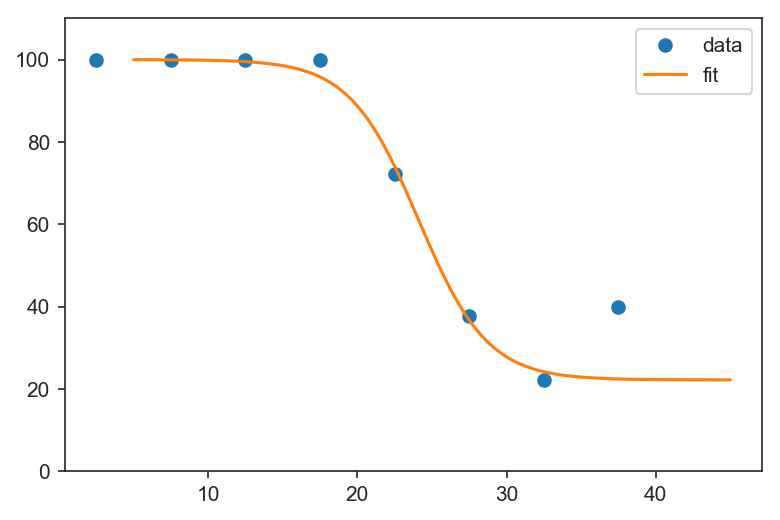

In [59]:
# From https://gist.github.com/andrewgiessel/5684769

import numpy as np
import pylab
from scipy.optimize import curve_fit

def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

# xdata = np.array([0.0,   1.0,  3.0, 4.3, 7.0,   8.0,   8.5, 10.0, 12.0])
# ydata = np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99])

# lowct = round(20.23532793139344)
lowct = round(25)

xdata = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5])
# ydata = np.array([np.NaN, np.NaN, 100.0, 80.72289156626506, 52.459016393442624, 38.70967741935484, 30.0, 33.333333333333336])
ydata = np.array([100.,         100.,         100.,         100.,          72.34042553, 37.77777778,  22.22222222,  40.])

ydata[np.isnan(ydata)] = 100

xdata_norm = xdata - lowct
ydata_norm = (ydata - ydata.min())/(ydata.max() - ydata.min())

popt, pcov = curve_fit(sigmoid, xdata_norm, ydata_norm)
# print(popt)

# x = np.linspace(-1, 15, 50)
x = np.linspace(-20, 20, 80)
y = sigmoid(x, *popt)

x = x + lowct
y = (ydata.max() - ydata.min()) * y + ydata.min()

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 110)
pylab.legend(loc='best')
pylab.show()